# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [6]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [10]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [11]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Figure 4

## Snapshots of the simulation

In [9]:
!pvpython /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/pv_snapshot_chromatin.py /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/

!cp /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/snapshot_chromatin_last.png Figure4/two_patch_snapshot.png

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Final snapshot of the baseline simulation at 3um separation and Ke=100.

<img width="50%" src="Figure4/two_patch_snapshot.png?raw=true"></img>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


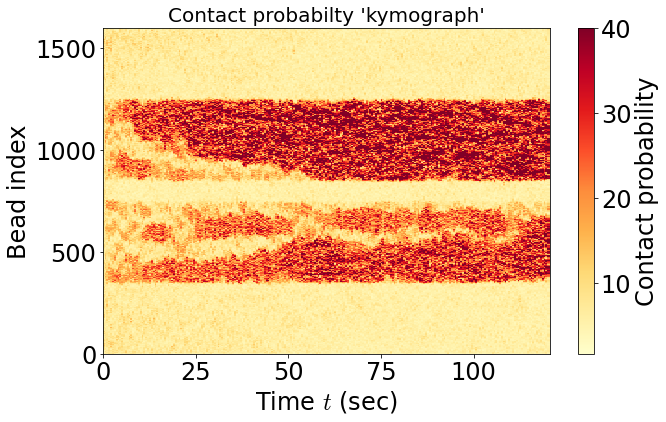

In [ ]:
h5_contact_file = ceph_path / "DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


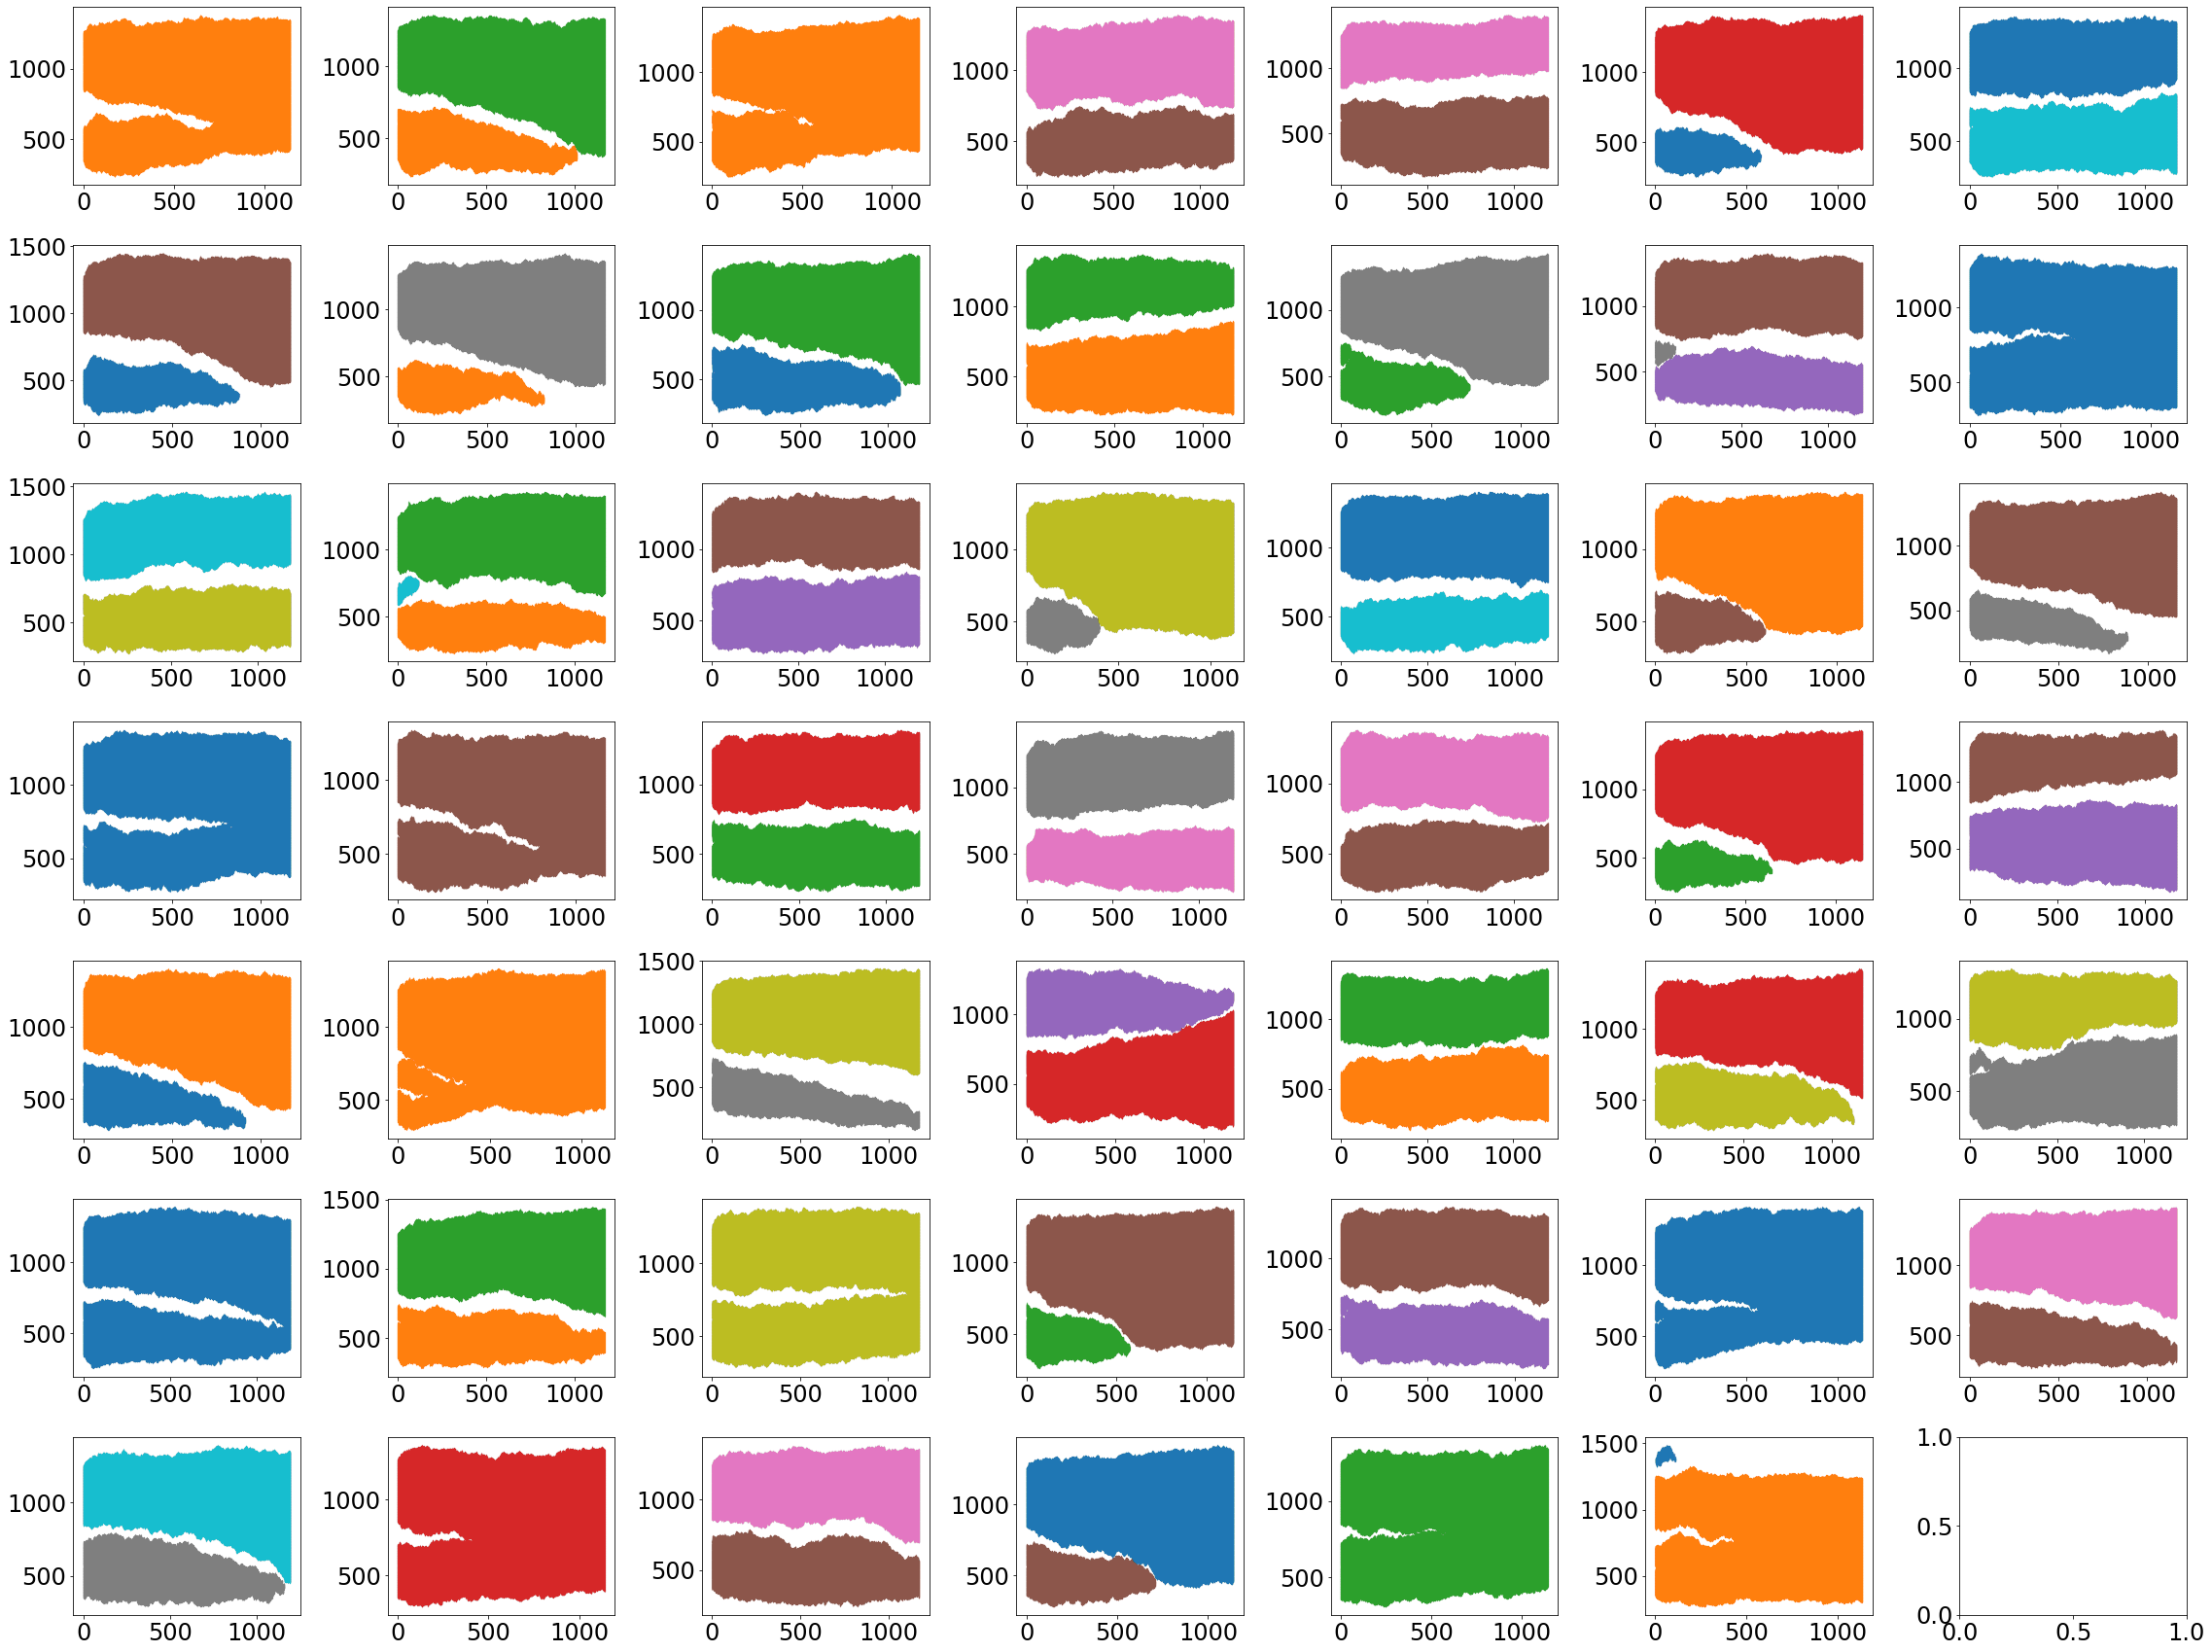

In [ ]:
data_path = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

large_tree_length = 200

merge_events = 0
dissovle_events = 0
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))
for i in range(graph_side_length):
    for j in range(graph_side_length):
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []
            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                trees += [tree]


            # Graph all clusters
            for tree, color in zip(trees, tableau10_colors):
                if len(tree.clusters) < large_tree_length:
                    continue
                for clust in tree.clusters:
                    _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
        except:
            raise

fig.tight_layout()




In [ ]:
data_path = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

large_tree_length = 240

merge_life_times = []
dissovle_life_times = [] 
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

# fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))
n = 0
for i in range(graph_side_length):
    for j in range(graph_side_length):
        n += 1
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []
            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                if len(tree.clusters) < large_tree_length:
                    continue
                trees += [tree]
                
            assert len(trees) > 0, "No trees found in sim"

            if len(trees) > 1: 
                trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)[:2]
            else: # Only 1 tree exists in sim, so must have merged
                branch_root = trees[0].get_branch_roots()[1]
                merge_life_times += [branch_root.time]
                print(f"Merge event at time {branch_root.time}")
                continue
            
            if trees[1].clusters[0].time < last_time:
                dissovle_life_times += [trees[1].clusters[0].time]
                print(f"{n} Dissolve event at time {trees[1].clusters[0].time}")
                continue

            nothing_events += 1

            # # Graph all clusters
            # for tree, color in zip(trees, tableau10_colors):
            #     for clust in tree.clusters:
            #         _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
        except:
            raise

fig.tight_layout()




Merge event at time 742.5
Dissolve event at time 1010.0
Merge event at time 577.0
Dissolve event at time 577.5
Dissolve event at time 876.5
Dissolve event at time 818.5
Dissolve event at time 1071.5
Dissolve event at time 713.5
Merge event at time 600.0
Dissolve event at time 396.0
Dissolve event at time 606.0
Dissolve event at time 885.5
Merge event at time 840.5
Merge event at time 799.5
Dissolve event at time 644.5
Dissolve event at time 914.0
Merge event at time 380.5
Dissolve event at time 1122.5
Merge event at time 1174.0
Merge event at time 1144.0
Dissolve event at time 572.0
Merge event at time 998.5
Dissolve event at time 1159.0
Merge event at time 419.5
Dissolve event at time 707.5
Merge event at time 588.5
Dissolve event at time 109.5


In [ ]:
data_path = ceph_path / "DynCondPaper/24-03-07_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

large_tree_length = 240

merge_life_times = []
dissovle_life_times = [] 
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

# fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))
n = 0
for i in range(graph_side_length):
    for j in range(graph_side_length):
        n += 1
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []
            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                if len(tree.clusters) < large_tree_length:
                    continue
                trees += [tree]
                
            assert len(trees) > 0, "No trees found in sim"

            if len(trees) > 1: 
                trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)[:2]
            else: # Only 1 tree exists in sim, so must have merged
                branch_root = trees[0].get_branch_roots()[1]
                merge_life_times += [branch_root.time]
                print(f"Merge event at time {branch_root.time}")
                continue
            
            if trees[1].clusters[0].time < last_time:
                dissovle_life_times += [trees[1].clusters[0].time]
                print(f"{n} Dissolve event at time {trees[1].clusters[0].time}")
                continue

            nothing_events += 1

            # # Graph all clusters
            # for tree, color in zip(trees, tableau10_colors):
            #     for clust in tree.clusters:
            #         _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
        except:
            raise

fig.tight_layout()




Merge event at time 742.5
Dissolve event at time 1010.0
Merge event at time 577.0
Dissolve event at time 577.5
Dissolve event at time 876.5
Dissolve event at time 818.5
Dissolve event at time 1071.5
Dissolve event at time 713.5
Merge event at time 600.0
Dissolve event at time 396.0
Dissolve event at time 606.0
Dissolve event at time 885.5
Merge event at time 840.5
Merge event at time 799.5
Dissolve event at time 644.5
Dissolve event at time 914.0
Merge event at time 380.5
Dissolve event at time 1122.5
Merge event at time 1174.0
Merge event at time 1144.0
Dissolve event at time 572.0
Merge event at time 998.5
Dissolve event at time 1159.0
Merge event at time 419.5
Dissolve event at time 707.5
Merge event at time 588.5
Dissolve event at time 109.5


<BarContainer object of 3 artists>

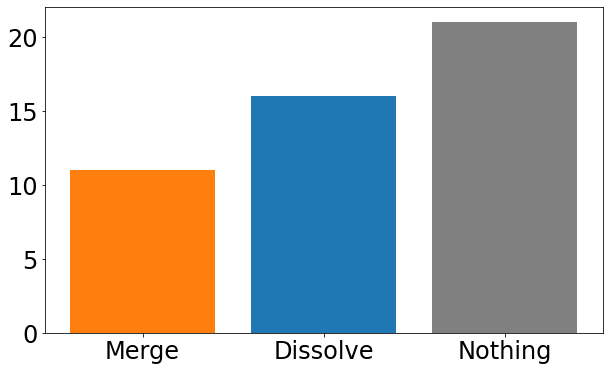

In [ ]:
# Bar graph of merge events vs dissolve events vs nothing events
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.bar(['Merge', 'Dissolve', 'Nothing'], [len(merge_life_times), len(dissovle_life_times), nothing_events], color=['tab:orange', 'tab:blue', 'grey'])